# Composer Publication Network

In [1]:
import numpy as np
import random
random.seed(10)
import pandas as pd
import os

# Plotting
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns

# Networks
import networkx as nx
from networkx.algorithms.community import louvain_communities

# Stats
import pingouin as pg
from scipy.stats import uniform

# Progress bars
from tqdm import tqdm
tqdm.pandas()

import warnings
import json
sns.set_style('white')

# Preparations for Exporting Plots

In [2]:
def export_and_plot(fig, file_name, width=585):
    path = os.path.join('plots', f'{file_name}.json')
    json_data = fig.to_json()
    with open(path, 'w') as f:
            f.write(json_data)

    fig.update_layout(width=width)
    fig.show()

# Source Documents

In [3]:
# import main dataset
wd = os.getcwd()
lute_path = os.path.join(wd, 'data', 'data_sets', 'lute_data.csv')
lute_df = pd.read_csv(lute_path)

# clean Date column
lute_df['Date'] = lute_df['Date'].str.replace('[^0-9]','', regex=True).astype(int)

# import cleaned composer names and rename composers in the main dataset
names_path = os.path.join(wd, 'data', 'data_sets', 'cleaned_composers.csv')
names_df = pd.read_csv(names_path, encoding='latin-1', index_col='Composer')
rename = lambda x: names_df.loc[x].cleaned_name
lute_df['Composer'] = lute_df['Composer'].apply(rename)

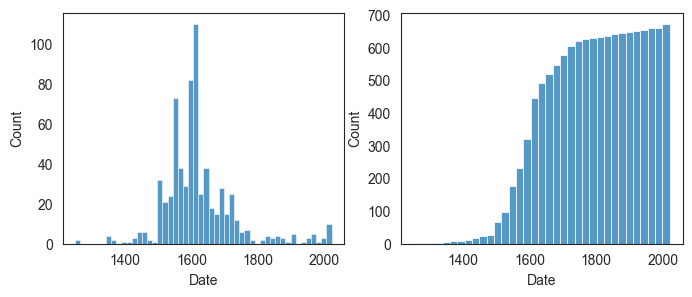

In [4]:
# plot histogram of the (cumulative) number of publications/documents with respect to time
sources = lute_df.drop_duplicates(subset=['Document', 'Date']).sort_values('Date').copy()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,3))
sns.histplot(data=sources, x='Date', bins=50, ax=axs[0])
sns.histplot(data=sources, x='Date', cumulative=True, ax=axs[1])
plt.show()

In [5]:
# looking at the graph above, we make cut-off at 1800 and exclude modern publications from the further analysis
lute_df = lute_df.query('Date < 1800')

# Publication History of Newsidler, da Milano, Dowland, and Vallet

In [6]:
from scipy.stats import uniform

# stripplot of sources for four important composers
plot_comps = ['Hans Newsidler', 'Francesco da Milano', 'John Dowland', 'Nicolas Vallet']
comp_sources = lute_df.query("Composer in @plot_comps").drop_duplicates(subset=['Composer', 'Document', 'Date']).sort_values('Date').copy()

comp_sources['composer_pos'] = comp_sources.Composer.replace({'Hans Newsidler': 1, 'Francesco da Milano': 2, 'John Dowland':3, 'Nicolas Vallet': 4})


random_seed = 42
jitter = uniform.rvs(-0.15, 0.3, len(comp_sources))
comp_sources['composer_pos'] = comp_sources['composer_pos'] + jitter

comp_sources.loc[(comp_sources['Composer'] == 'Hans Newsidler') & (comp_sources['Date'] == 1570), 'composer_pos'] = 1
comp_sources.loc[(comp_sources['Composer'] == 'Francesco da Milano') & (comp_sources['Date'] == 1570), 'composer_pos'] = 2
comp_sources.loc[(comp_sources['Composer'] == 'Francesco da Milano') & (comp_sources['Date'] == 1610), 'composer_pos'] = 2

comp_sources.loc[(comp_sources['Composer'] == 'John Dowland') & (comp_sources['Date'] == 1590), 'composer_pos'] = 2.9
comp_sources.loc[11940, 'composer_pos'] = 3

C:\Users\jakob\AppData\Local\Temp\ipykernel_7196\1123167532.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comp_sources['composer_pos'] = comp_sources.Composer.replace({'Hans Newsidler': 1, 'Francesco da Milano': 2, 'John Dowland':3, 'Nicolas Vallet': 4})


In [7]:
# stripplot of sources for four important composers
plot_comps = ['Hans Newsidler', 'Francesco da Milano', 'John Dowland', 'Nicolas Vallet']
comp_sources = lute_df.query("Composer in @plot_comps").drop_duplicates(subset=['Composer', 'Document', 'Date']).sort_values('Date').copy()

comp_sources['composer_pos'] = comp_sources.Composer.replace({'Hans Newsidler': 1, 'Francesco da Milano': 2, 'John Dowland':3, 'Nicolas Vallet': 4})

random_seed = 1
jitter = uniform.rvs(-0.15, 0.3, len(comp_sources), random_state=random_seed)
comp_sources['composer_pos'] = comp_sources['composer_pos'] + jitter

comp_sources.loc[(comp_sources['Composer'] == 'Hans Newsidler') & (comp_sources['Date'] == 1570), 'composer_pos'] = 1
comp_sources.loc[(comp_sources['Composer'] == 'Francesco da Milano') & (comp_sources['Date'] == 1570), 'composer_pos'] = 2
comp_sources.loc[(comp_sources['Composer'] == 'Francesco da Milano') & (comp_sources['Date'] == 1610), 'composer_pos'] = 2

comp_sources.loc[11940, 'composer_pos'] = 3
comp_sources.loc[(comp_sources['Composer'] == 'John Dowland') & (comp_sources['Date'] == 1590), 'composer_pos'] = 3


fig = go.Figure()

comp_colors = ['#7eb0d5', '#fd7f6f', '#b2e061', '#bd7ebe']

for comp in zip(plot_comps, comp_colors):

    composer, color = comp
    comp_sources_ind = comp_sources.query(f"Composer == '{composer}'")

    nation_nodes = go.Scatter(
        x=comp_sources_ind.Date,
        y=comp_sources_ind.composer_pos,
        mode='markers',
        marker=dict(
            size=20,
            color=color,
            line=dict(width=1, color='white'),
            opacity=0.9
        ),
        name=composer
    )
    fig.add_trace(nation_nodes)


annotation_style = dict(
    showarrow=False,
    font=dict(size=15, color="#303030"),
    bordercolor="#303030",
    borderwidth=1,
    borderpad=3,
    bgcolor='white',
    opacity=1
)
line_style = dict(type="line", line=dict(width=1), opacity=0.7)

fig.add_annotation(x=1590, y=1.2, text='ms res. 429', **annotation_style)
fig.add_shape(x0=1590, y0=1.2, x1=1570, y1=1, **line_style)
fig.add_shape(x0=1590, y0=1.2, x1=1570, y1=2, **line_style)


fig.add_annotation(x=1582, y=4, text='ms z.3.2.13:Marsh lute book', **annotation_style)
fig.add_shape(x0=1582, y0=4, x1=1610, y1=3, **line_style)
fig.add_shape(x0=1582, y0=4, x1=1610, y1=2, **line_style)


fig.update_layout(
    title=dict(text='Composer Source Documents', font=dict(size=22)),
    height=320,
    title_x=0,
    title_y=0.98,
    margin=dict(l=1,r=0,b=0,t=50),
    template='simple_white',
    legend=dict(x=0.02, y=1, xanchor='left', yanchor='top'),
    yaxis=dict(showticklabels=False, ticks=''),
    xaxis=dict(range=[1523, 1630]),
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
)


export_and_plot(fig, 'document_stripplot')

C:\Users\jakob\AppData\Local\Temp\ipykernel_7196\933841812.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comp_sources['composer_pos'] = comp_sources.Composer.replace({'Hans Newsidler': 1, 'Francesco da Milano': 2, 'John Dowland':3, 'Nicolas Vallet': 4})


In [8]:
def get_shared_docs(comp_1, comp_2):
    """
    Returns list of documents that contain music from both comp_1 and comp_2.
    """
    comp_1_docs = set(comp_sources.query("Composer == @comp_1")['Document'])
    comp_2_docs = set(comp_sources.query("Composer == @comp_2")['Document'])
    shared_docs = comp_1_docs.intersection(comp_2_docs)    
    return shared_docs

shared_docs = get_shared_docs('Francesco da Milano', 'John Dowland')
comp_sources[['Composer', 'Date', 'Document']].query("Document in @shared_docs").sort_values(['Composer', 'Date'])

,Composer,Date,Document
1698,Francesco da Milano,1595,ms add 3056:Cosens lute book
13801,Francesco da Milano,1595,ms M1353:Hirsch lute book
1755,Francesco da Milano,1600,Dd.2.11b
1694,Francesco da Milano,1610,ms z.3.2.13:Marsh lute book
8052,Francesco da Milano,1619,ms ii.6.15:Dlugorai lute book
505,John Dowland,1595,ms M1353:Hirsch lute book
491,John Dowland,1595,ms add 3056:Cosens lute book
498,John Dowland,1600,Dd.2.11b
582,John Dowland,1610,ms z.3.2.13:Marsh lute book
8062,John Dowland,1619,ms ii.6.15:Dlugorai lute book


# Select Composers for Network Graph

In [107]:
def get_comps_with_n_docs(df, n):
    """
    Returns the composers in the dataframe whose music appears in at least n documents.
    """
    imp_comps = []
    for comp in df.Composer.unique():
        if len(df.query('Composer == @comp')[['Document', 'Date', 'Source']].drop_duplicates()) >= n:
            imp_comps.append(comp)

    print('total composers:', len(df.Composer.unique()))        
    print('composers with at least', n, 'source documents:', len(imp_comps))
    return imp_comps


def get_docs_with_n_comps(df, n):
    """
    Returns the documents in the dataframe that contain music by at least n composers.
    """
    imp_docs = []
    for doc in df.Document.unique():
        if len(df.query('Document == @doc').Composer.drop_duplicates()) >= n:
            imp_docs.append(doc)

    print('total docs:', len(df.Document.unique()))        
    print('docs with at least', n, 'comps:', len(imp_docs))
    return imp_docs


# select composers to be included in the network
imp_comp = get_comps_with_n_docs(lute_df, 3)
imp_docs = get_docs_with_n_comps(lute_df, 3)

selected_comps = lute_df.query(
  'Composer in @imp_comp' # min 3 docs per composer because else the network is dominated by a few documents with few connections to the rest
  ' and Document in @imp_docs' # min 3 comps per doc to make the whole network a little less connected
  ' and Arranger.isna()'
  ' and Date < 1750'
  ' and Composer != "Anonymous"'
  ' and Document not in ["unknown source", "Unknown source"]'
).Composer.unique()

len(selected_comps)

total composers: 517
composers with at least 3 source documents: 143
total docs: 530
docs with at least 3 comps: 80


124

# For How Long Did the Composers Get Published? 

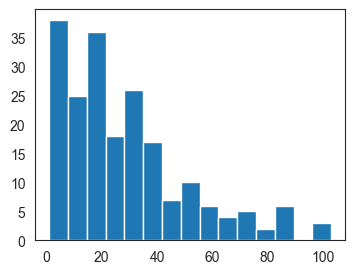

In [151]:
# import composer dataset (obtained by scraping Musicalics and Composers-Classical-Music)
comp_path = os.path.join(wd, 'data', 'data_sets', 'scraped_composer_data_cleaned.csv')
comp_df = pd.read_csv(comp_path, index_col='composer')
comp_df['active_year'] = (comp_df['date_of_death'] + comp_df['date_of_birth']) / 2

comp_documents = lute_df.query('Composer != "Anonymous and Composer in @selected_comps"').drop_duplicates(subset=['Composer', 'Document', 'Date']).sort_values('Date').copy()
comp_documents = pd.merge(comp_documents, comp_df, how='left', left_on='Composer', right_index=True)


plt.figure(figsize=(4,3))
publishing_timeframes = comp_documents.groupby('Composer').Date.max() - comp_documents.groupby('Composer').Date.min()
publishing_timeframes = publishing_timeframes.reset_index().query('Date < 120 and Date > 0')
plt.hist(publishing_timeframes.Date, bins=15)
plt.show()

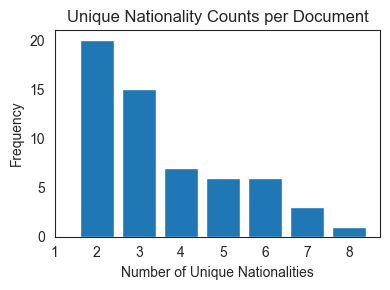

In [238]:
# Count the number of composers per document
composer_counts = comp_documents['Document'].value_counts()

multi_composer_docs = composer_counts[composer_counts > 2].index.to_list()
multi_composer_docs_df = comp_documents.query('Document in @multi_composer_docs')

unique_nationalities = multi_composer_docs_df.groupby('Document')['nationality'].nunique()
frequency_distribution = unique_nationalities.value_counts().sort_index()


plt.figure(figsize=(4, 3))
plt.bar(frequency_distribution.index[1:], frequency_distribution.values[1:])
plt.xlabel('Number of Unique Nationalities')
plt.ylabel('Frequency')
plt.title('Unique Nationality Counts per Document')
plt.xticks(frequency_distribution.index)
plt.tight_layout()
plt.show()

In [237]:
# Create subplots
fig = make_subplots(rows=1, cols=2)

# Add the first plot
fig.add_trace(
    go.Histogram(
        x=publishing_timeframes['Date'],
        nbinsx=25,
        name='Publishing Timeframes',
        marker=dict(
            line=dict(width=0),
            color='#636efa',
            opacity=0.9,
        ),
    ),
    row=1, col=1
)


# Add the second plot
fig.add_trace(
    go.Bar(
        x=frequency_distribution.index[1:],
        y=frequency_distribution.values[1:],
        name='Unique Nationality Counts',
        width=0.8,
        marker=dict(
            opacity=0.9,
            color='#ef553b'
        ),
    ),
    row=1, col=2
)

# Update layout
fig.update_layout(
    title=dict(text='Publication Periods and Nationalities per Document', font=dict(size=22)),
    height=350,
    title_x=0,
    title_y=0.98,
    margin=dict(l=1, r=0, b=0, t=50),
    template='simple_white',
    showlegend=False,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
)

fig.update_xaxes(title_text='Years Between First and Last Publication', row=1, col=1)
fig.update_yaxes(title_text='Count', row=1, col=1)

fig.update_xaxes(title_text='Unique Nationalities per Document', row=1, col=2, dtick=1, ticks='')
fig.update_yaxes(title_text='Count', row=1, col=2)

export_and_plot(fig, 'pub_periods_and_nat_counts_per_doc', width=630)

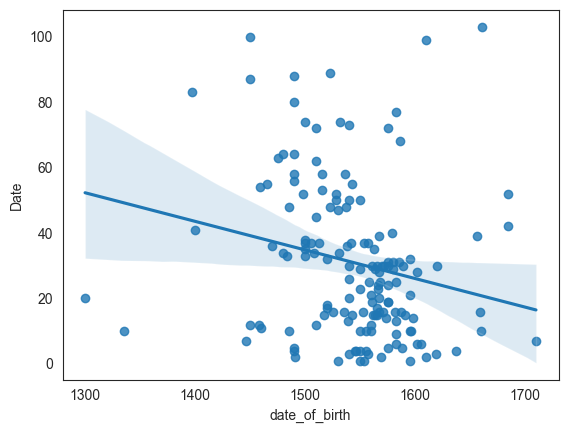

,n,r,CI95%,p-val,BF10,power
pearson,152,-0.212692,"[-0.36, -0.06]",0.008519,3.124,0.753083


In [10]:
# is the length of the publication history correlated with date of birth (earlier composers have more time to get published)?
comp_pub_df = comp_df.merge(publishing_timeframes, left_index=True, right_index=True)
sns.regplot(
    x = comp_pub_df.query('Date > 0').date_of_birth,
    y = comp_pub_df.query('Date > 0').Date
)
plt.show()
pg.corr(
    x = comp_pub_df.query('Date > 0').date_of_birth,
    y = comp_pub_df.query('Date > 0').Date
)

# Instantiate Graph

The graph will be undirected and the edges weighted proportional to the number of documents that contain pieces of both composers.

In [12]:
def compute_edges(df, imp_comp, min_shared_docs=1):
    """
    Returns edges between selected composers based on shared documents in the dataset.
    min_shared_docs can be used to make the network more or less connected.
    """
    # get (unordered) composer pairs
    comp_pairs = []
    for i, comp_1 in enumerate(imp_comp):
        for comp_2 in imp_comp[i+1:]:
            comp_pairs.append((comp_1, comp_2))
            
    # dict with set of documents for each composer        
    comp_docs = {}
    for comp in imp_comp:
        comp_docs[comp] = set(df[df.Composer==comp].Document)

    # create edges for composers that have documents in common; edge weights are number of common documents
    edges = []
    for pair in comp_pairs:
        comp_1 = pair[0]
        comp_2 = pair[1]     
        common_docs = comp_docs[comp_1].intersection(comp_docs[comp_2])
        nbr_common_docs = len(common_docs)
        if nbr_common_docs > 0:
            edge = (comp_1, comp_2, {"weight":nbr_common_docs})
            edges.append(edge)
            
    edges = [edge for edge in edges if edge[2]['weight'] >= min_shared_docs]           
    return imp_comp, edges



def trim_edges(G, min_degree, n_remove):
    """
    Remove edges from G. Favor highly connected parts of the network.
    """  
    def weigh_edges(F):
        """
        Weigh edges and normalize to probabilities.
        """
        weights = {}
        for u, v in F.edges():
            weight = F.degree[u] * F.degree[v]
            weights[(u, v)] = weight
        total = sum(weights.values())
        probas = {e: w / total for e, w in weights.items()}
        return probas
    
    F = G.copy()
    removed_edges = 0
    probas = weigh_edges(F)
    
    while removed_edges < n_remove and len(probas) > 0:
        edge = random.choices(list(probas.keys()), weights=probas.values(), k=1)[0]
        u, v = edge
        
        if F.has_edge(u, v) and F.degree[u] > min_degree and F.degree[v] > min_degree:
            F.remove_edge(u, v)
            removed_edges += 1
            probas = weigh_edges(F)
        else:
            probas.pop(edge)
        
        # If no edges can be removed anymore, break the loop
        if not any(F.degree[n] > min_degree for n in F.nodes()):
            print("All nodes have <= min_degree.")
            break

    return F

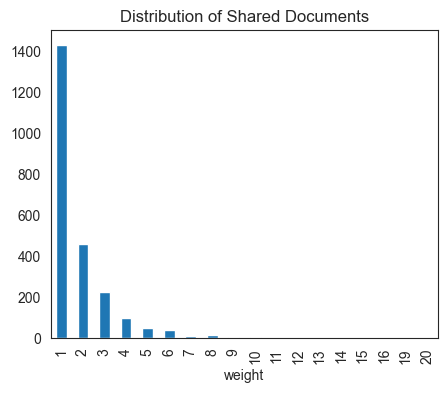

In [13]:
# create a dataframe based on computed edges between selected composers
comps, edges = compute_edges(lute_df, selected_comps)
edges_df = pd.DataFrame([(name1, name2, weight['weight']) for name1, name2, weight in edges], columns=['name1', 'name2', 'weight'])

# plot distribution of weights (i.e. number of shared documents)
fig = plt.figure(figsize=(5,4))
edges_df.groupby('weight').size().plot.bar()
plt.title('Distribution of Shared Documents')
plt.show()

In [14]:
def top_edges_for_comp(comp, n=5):
    """
    Return top n composers with the most shared to documents for a given composer.
    """
    return edges_df.query("name1 == @comp or name2 == @comp").sort_values('weight', ascending=False).head(n)
    
top_edges_for_comp('John Dowland', 10)

,name1,name2,weight
533,John Dowland,John Johnson,20
527,John Dowland,Anthony Holborne,19
127,Daniel Bacheler,John Dowland,19
278,Francis Cutting,John Dowland,15
8,Richard Allison,John Dowland,14
545,John Dowland,Robert Johnson,12
559,John Dowland,Robert Ballard,10
571,John Dowland,Jean Perrichon,10
543,John Dowland,Peter Philips,10
554,John Dowland,Hans Leo Hassler,8


Number of nodes: 124
Number of edges: 2361


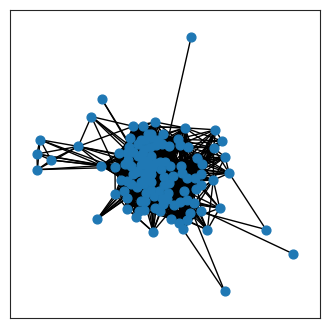

In [15]:
# instantiate main graph
G = nx.Graph()
G.add_nodes_from(comps)
G.add_edges_from(edges)

# get largest connected component of G (not really necessary if there is only one)
largest_cc_G = max(nx.connected_components(G), key=len)
G_sub = G.subgraph(largest_cc_G).copy()

print(f'Number of nodes: {len(G_sub)}')
print(f'Number of edges: {len(G_sub.edges)}')

# plot G
fig, ax = plt.subplots(figsize=(4,4))
pos = nx.spring_layout(G, seed=4)
nx.draw_networkx(G_sub, pos, node_size=40, with_labels=False, width=1)
plt.show()

# Main Graph Plots

Ok, let's now try to create a pleasant-looking plot of largest weakly connected subgraph of our network. To make the plot more informative, we (i) make the size of the nodes proportional to the number of pieces the composers have in the dataset, (ii) color the nodes according to the composers' nationality/active_year/cluster, and (iii) add labels for some important composers.

In [16]:
# get node positions using the networkx spring algorithm
pos = nx.spring_layout(G_sub, seed=1)
graph_df = pd.DataFrame(pos).transpose()
graph_df = graph_df.rename({0:'x_pos', 1:'y_pos'}, axis=1)

# get composer info
graph_df = graph_df.merge(comp_df, how='left', right_index=True, left_index=True)
graph_df['nationality_other'] = graph_df['nationality'].apply(lambda x: x if (x in ["Italy", "England", "France", "Germany"]) else 'Other/NaN')

# get node sizes as a function of the number of pieces a composer has in the dataset
count_df = lute_df.groupby(by='Composer')[['Title']].count()
graph_df = graph_df.merge(count_df, how='left', left_index=True, right_index=True)
graph_df = graph_df.rename(columns={'Title':'node_size'})

# area of nodes is proportional to the number of pieces; a value of 10 is added to ensure nodes with less important composers have a certain minimum size
graph_df['node_size'] = 3.2 * np.sqrt(graph_df['node_size'] / np.pi) + 11

graph_df.head()

,x_pos,y_pos,date_of_birth,birth_town,birth_country,date_of_death,death_town,death_country,nationality,active_year,nationality_other,node_size
Richard Allison,0.025127,-0.022322,1565.0,NaN,England,1610.0,NaN,England,England,1587.5,England,25.996834
Robert Askue,0.174057,-0.118767,NaN,NaN,NaN,NaN,NaN,NaN,England,NaN,England,15.422325
Daniel Bacheler,0.030630,-0.126492,1572.0,Aston Clinton,England,1619.0,Kent,England,England,1595.5,England,31.425845
Charles Bocquet,-0.028002,-0.034765,NaN,NaN,NaN,1570.0,NaN,NaN,France,NaN,France,21.680930
Francis Cutting,0.057376,-0.027249,1583.0,London,England,1623.0,London,NaN,England,1603.0,England,33.404508


Let's take a look at the nationalities and active years (defined as the middle point between a composer's birth and death year) of all composers in the network.

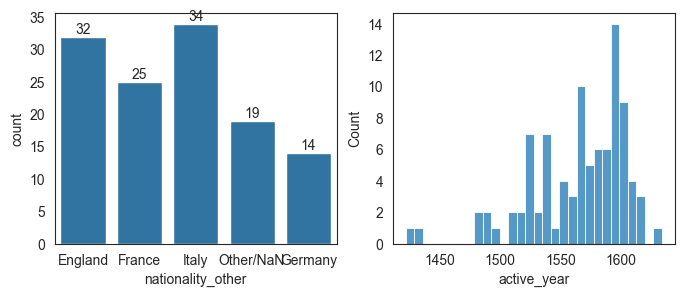

In [17]:
# demographic variables of node composers
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,3))
sns.countplot(data=graph_df, x='nationality_other', ax=axs[0])
axs[0].bar_label(axs[0].containers[0])
sns.histplot(data=graph_df, x='active_year', bins=30, ax=axs[1])

plt.show()

Now the main plot.

In [18]:
fig = go.Figure()

# add edge traces 
G_reduced = trim_edges(G, 18, 1500)
for edge in G_reduced.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    fig.add_trace(
        go.Scatter(
            x=[x0, x1, None],
             y=[y0, y1, None],
             mode='lines',
             line=dict(width=0.3, color='#b3bfd1'), # '#b3bfd1'
             opacity=0.7,
             name='Edges',
             showlegend=False
        )
    ) 

# add node traces (we are adding each nation separately, so we can have missing/NaN at the lowest level)
legend_ranks = {'England':1, 'Italy':2, 'France':3, 'Germany':4, 'Other/NaN':5}
graph_df['nat_color'] = graph_df['nationality_other'].map({'Italy':'#fd7f6f', 'England':'#b2e061', 'France':'#bd7ebe', 'Germany':'#7eb0d5', 'Other/NaN':'lightgrey'})

for nation in ['Other/NaN', 'Italy', 'England', 'Germany', 'France']:
    graph_df_nation = graph_df.query(f"nationality_other == '{nation}'")

    nation_nodes = go.Scatter(
        x=graph_df_nation.x_pos,
        y=graph_df_nation.y_pos,
        mode='markers',
        marker=dict(
            size=graph_df_nation.node_size,
            color=graph_df_nation.nat_color,
            line=dict(color='white', width=1),
            opacity=0.9
        ),
        hovertemplate='%{text}',
        hoverlabel=dict(bgcolor='white', font=dict(color='black'), namelength=0),
        text=graph_df_nation.index,
        legendrank=legend_ranks[nation],
        name=nation
    )
    fig.add_trace(nation_nodes)

# add labels for important composers
for comp in plot_comps:    
    fig.add_annotation(
        x=graph_df.loc[comp].x_pos,
        y=graph_df.loc[comp].y_pos,
        text=comp,
        arrowwidth=1,
        arrowcolor='#303030',
        font=dict(size=14, color="#303030"),
        bordercolor='#303030',
        borderwidth=1,
        bgcolor='white',
        opacity=0.8
    )

# general layout        
fig.update_layout(
    title=dict(text='Composer Publication Network', font=dict(size=25)),
    title_x=0,
    title_y=0.98,
    margin=dict(l=0,r=0,b=0,t=50),
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    showlegend=True,
    legend=dict(x=0.02, y=0.98, xanchor='left', yanchor='top', font=dict(size=13), title='Nationality', bgcolor='rgba(0,0,0,0)'),
    hovermode='closest',
    height=660
)
        
# zoom in on network center    
fig.update_xaxes(
    visible=False,
    range=[-0.48, 0.56]
)
fig.update_yaxes(
    visible=False,
    range=[-0.62, 0.55]
)


export_and_plot(fig, 'network_graph_nationality', width=650)

In [19]:
len(G_sub.edges), len(G_reduced.edges)

(2361, 1027)

In [20]:
fig = go.Figure()

# add edge traces 
for edge in G_reduced.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    fig.add_trace(
        go.Scatter(
            x=[x0, x1, None],
            y=[y0, y1, None],
            mode='lines',
            line=dict(width=0.3, color='#b3bfd1'),
            opacity=0.7,
            name='Edges',
            showlegend=False
        )
    ) 

graph_df_dates = graph_df.query('not active_year.isna()')
graph_df_no_dates = graph_df.query('active_year.isna()')

# add node traces without dates (grey)
nodes_no_date = go.Scatter(
    x=graph_df_no_dates.x_pos,
    y=graph_df_no_dates.y_pos,
    mode='markers',
    marker=dict(
        size=graph_df_no_dates.node_size,
        color='lightgrey',
        line=dict(color='white', width=1),
        opacity=0.9
    ),
    hovertemplate='%{text}',
    hoverlabel=dict(bgcolor='white', font=dict(color='black'), namelength=0),
    text=graph_df_no_dates.index,
    showlegend=False
)
fig.add_trace(nodes_no_date)

# add node traces with dates (continuous color scale)
nodes_date = go.Scatter(
    x=graph_df_dates.x_pos,
    y=graph_df_dates.y_pos,
    mode='markers',
    marker=dict(
        size=graph_df_dates.node_size,
        color=graph_df_dates['active_year'],
        colorscale='Magma',
        cmin=1490,
        cmax=1615,
        colorbar=dict(
            title='Active Year',
            len=0.4,
            xanchor='left',
            yanchor='top',
            x=0.02,
            y=0.98,
            thickness=30
        ),
        line=dict(color='white', width=1),
        opacity=0.9
    ),
    hovertemplate='%{text}',
    hoverlabel=dict(bgcolor='white', font=dict(color='black'), namelength=0),
    text=graph_df_dates.index,
    showlegend=False
)
fig.add_trace(nodes_date)

# add labels for important composers
for comp in plot_comps:    
    fig.add_annotation(
        x=graph_df.loc[comp].x_pos,
        y=graph_df.loc[comp].y_pos,
        text=comp,
        arrowwidth=1,
        arrowcolor='#303030',
        font=dict(size=14, color="#303030"),
        bordercolor='#303030',
        borderwidth=1,
        bgcolor='white',
        opacity=0.8
    )

# general layout        
fig.update_layout(
    title=dict(text='Composer Publication Network', font=dict(size=25)),
    title_x=0,
    title_y=0.98,
    margin=dict(l=0,r=0,b=0,t=50),
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    showlegend=True,
    legend=dict(x=0.02, y=0.98, xanchor='left', yanchor='top', font=dict(size=13), title='Nationality', bgcolor='rgba(0,0,0,0)'),
    hovermode='closest',
    height=660
)
        
# zoom in on network center    
fig.update_xaxes(
    visible=False,
    range=[-0.48, 0.56]
)
fig.update_yaxes(
    visible=False,
    range=[-0.62, 0.55]
)


export_and_plot(fig, 'network_graph_date', width=650)

In [21]:
# use the louvain_communities to find clusters/communities based on modularity
communities = louvain_communities(G_sub, seed=9, resolution=0.9)
group_mapping = {0:"Group 1", 1:"Group 2", 2:"Group 3"}
groups = []

for comp in graph_df.index:
    for i, group in enumerate(communities):
            if comp in group:
                groups.append(group_mapping[i])
                
graph_df['Community'] = groups

In [22]:
fig = go.Figure()

# add edges
for edge in G_reduced.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    fig.add_trace(
        go.Scatter(
            x=[x0, x1, None],
            y=[y0, y1, None],
            mode='lines',
            line=dict(width=0.3, color='#b3bfd1'),
            opacity=0.7,
            name='Edges',
            showlegend=False
        )
    ) 

# add node traces for each community
unique_communities = graph_df['Community'].unique()

# default color cycle from plotly express
default_colors = px.colors.qualitative.Plotly
color_map = {community: default_colors[i % len(default_colors)] for i, community in enumerate(sorted(unique_communities))}

for community in unique_communities:
    community_df = graph_df[graph_df['Community'] == community]
    nodes = go.Scatter(
        x=community_df['x_pos'],
        y=community_df['y_pos'],
        mode='markers',
        marker=dict(
            size=community_df['node_size'],
            color=color_map[community],  # Use mapped color
            line=dict(color='white', width=1),
            opacity=0.9
        ),
        hovertemplate='%{text}',
        hoverlabel=dict(bgcolor='white', font=dict(color='black'), namelength=0),
        text=community_df.index,
        name=community
    )
    fig.add_trace(nodes)
    
# add labels for important composers
for comp in plot_comps:   
    fig.add_annotation(
        x=graph_df.loc[comp].x_pos,
        y=graph_df.loc[comp].y_pos,
        text=comp,
        arrowwidth=1,
        arrowcolor='#303030',
        font=dict(size=14, color="#303030"),
        bordercolor='#303030',
        borderwidth=1,
        bgcolor='white',
        opacity=0.8
    )

# general layout        
fig.update_layout(
    title=dict(text='Composer Publication Network', font=dict(size=25)),
    title_x=0,
    title_y=0.98,
    margin=dict(l=0,r=0,b=0,t=50),
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    showlegend=True,
    legend=dict(x=0.02, y=0.98, xanchor='left', yanchor='top', font=dict(size=13), title='Community', bgcolor='rgba(0,0,0,0)'),
    hovermode='closest',
    height=660
)
        
# zoom in on network center    
fig.update_xaxes(
    visible=False,
    range=[-0.48, 0.56]
)
fig.update_yaxes(
    visible=False,
    range=[-0.62, 0.55]
)

export_and_plot(fig, 'network_graph_community', width=650)

In [23]:
# shortest paths between composers
sp = nx.all_shortest_paths(G_sub, source='Nicolas Vallet', target='Hans Newsidler', weight=None, method='dijkstra')
list(sp)[:2]

[['Nicolas Vallet',
  'Daniel Bacheler',
  'Francesco da Milano',
  'Hans Newsidler'],
 ['Nicolas Vallet',
  'Charles Bocquet',
  'Francesco da Milano',
  'Hans Newsidler']]

# Centrality Measures


In [24]:
# list of networkx centrality measures
centrality_funcs = [
    (dict(G_sub.degree), 'Degree'),
    (nx.closeness_centrality(G_sub), 'Closeness Centrality'),
    (nx.betweenness_centrality(G_sub), 'Betweenness Centrality'),
    (nx.harmonic_centrality(G_sub), 'Harmonic Centrality')
]

# create dataframe for each centrality measure
centrality_dfs = [
    pd.DataFrame.from_dict(centrality_func, orient='index', columns=[name]).sort_values(by=name, ascending=False) for centrality_func, name in centrality_funcs
]

# concatenate them
centrality_df = pd.concat([df.reset_index(names=[f'Composer{i}']) for i, df in enumerate(centrality_dfs)], axis=1)
centrality_df.head(10)


,Composer0,Degree,Composer1,Closeness Centrality,Composer2,Betweenness Centrality,Composer3,Harmonic Centrality
0,John Dowland,90,John Dowland,0.778481,John Dowland,0.047615,John Dowland,106.166667
1,John Johnson,85,John Johnson,0.754601,Francesco da Milano,0.047223,John Johnson,103.666667
2,Francesco da Milano,83,Robert Ballard,0.740964,Pierre Guédron,0.045282,Francesco da Milano,102.166667
3,Robert Ballard,81,Anthony Holborne,0.736527,Anthony Holborne,0.034714,Robert Ballard,101.833333
4,Anthony Holborne,80,Richard Allison,0.732143,Claudin de Sermisy,0.027832,Anthony Holborne,101.333333
5,Daniel Bacheler,80,Francesco da Milano,0.732143,Matthäus Waissel,0.025605,Charles Bocquet,101.166667
6,Charles Bocquet,80,Charles Bocquet,0.732143,Orlando di Lasso,0.025498,Daniel Bacheler,101.166667
7,Francis Cutting,80,Daniel Bacheler,0.732143,Robert Ballard,0.024037,Richard Allison,100.833333
8,Richard Allison,79,Lorenzino Tracetti,0.723529,Lorenzino Tracetti,0.023342,Francis Cutting,100.666667
9,Robert Johnson,77,Robert Johnson,0.723529,Daniel Bacheler,0.022411,Robert Johnson,99.833333


In [25]:
centrality_df.head(10).Composer2.values

array(['John Dowland', 'Francesco da Milano', 'Pierre Guédron',
       'Anthony Holborne', 'Claudin de Sermisy', 'Matthäus Waissel',
       'Orlando di Lasso', 'Robert Ballard', 'Lorenzino Tracetti',
       'Daniel Bacheler'], dtype=object)

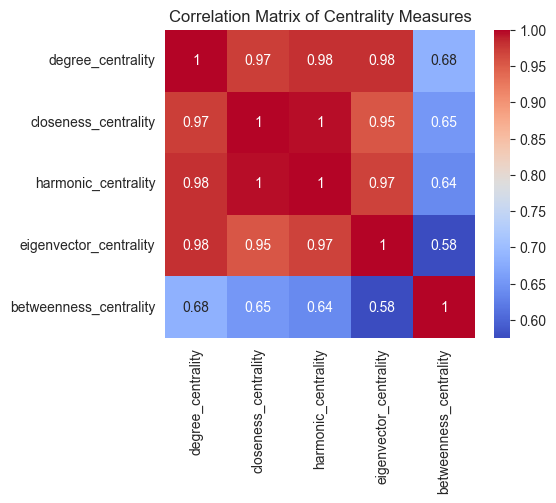

In [26]:
degree_centrality = nx.degree_centrality(G_sub)
closeness_centrality = nx.closeness_centrality(G_sub)
harmonic_centrality = nx.harmonic_centrality(G_sub)
eigenvector_centrality = nx.eigenvector_centrality(G_sub)
betweenness_centrality = nx.betweenness_centrality(G_sub)

cent_df = pd.DataFrame({
    'degree_centrality': degree_centrality,
    'closeness_centrality': closeness_centrality,
    'harmonic_centrality': harmonic_centrality,
    'eigenvector_centrality': eigenvector_centrality,
    'betweenness_centrality': betweenness_centrality
})

correlation_matrix = cent_df.corr()

plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Centrality Measures')
plt.show()

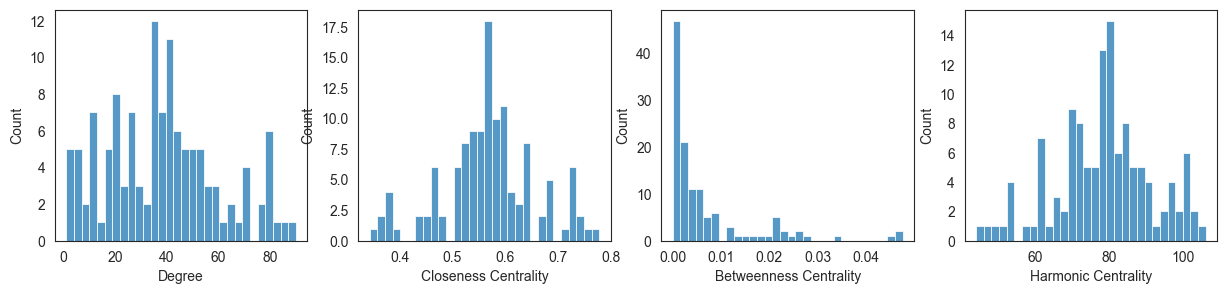

In [27]:
# plot distributions of different centrality measures
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(15,3))
for index, measure in enumerate(['Degree', 'Closeness Centrality', 'Betweenness Centrality', 'Harmonic Centrality']):
    sns.histplot(data=centrality_df, x=measure, bins=30, ax=axs[index])

plt.show()

# Assortativity for Nationality and Active Year

In [28]:
# assign nationality and active year as node attributs
for n in G_sub.nodes:
    G_sub.nodes[n]['nationality'] = graph_df.loc[n].nationality
    G_sub.nodes[n]['active_year'] = graph_df.loc[n].active_year

In [29]:
# disregard nodes with missing data.
nodes_with_nat = graph_df.dropna(subset=['nationality']).index.to_numpy()

# calculate mixing matrix and assortativity coefficient for the categorical nationality attribute
graph_nationalities = ['England', 'Italy', 'France', 'Germany', 'Belgium', 'Poland', 'Netherlands', 'Hungary', 'Switzerland']
mapping = dict(zip(graph_nationalities, list(range(9))))

assortativity_coeff_nat = round(nx.attribute_assortativity_coefficient(G_sub, 'nationality', nodes=nodes_with_nat), 3)
print(f'Assortativity coefficient: {assortativity_coeff_nat}')

mixing_matrix = pd.DataFrame(nx.attribute_mixing_matrix(G_sub, 'nationality', nodes=nodes_with_nat, mapping=mapping, normalized=True))
mixing_matrix.index = graph_nationalities
mixing_matrix.columns = graph_nationalities
mixing_matrix.round(3)

Assortativity coefficient: 0.076


,England,Italy,France,Germany,Belgium,Poland,Netherlands,Hungary,Switzerland
England,0.144,0.064,0.064,0.020,0.028,0.006,0.002,0.001,0.001
Italy,0.064,0.078,0.048,0.023,0.025,0.006,0.003,0.002,0.002
France,0.064,0.048,0.047,0.017,0.013,0.005,0.004,0.002,0.001
Germany,0.020,0.023,0.017,0.008,0.006,0.003,0.002,0.001,0.001
Belgium,0.028,0.025,0.013,0.006,0.010,0.002,0.001,0.000,0.001
Poland,0.006,0.006,0.005,0.003,0.002,0.000,0.001,0.000,0.000
Netherlands,0.002,0.003,0.004,0.002,0.001,0.001,0.000,0.000,0.000
Hungary,0.001,0.002,0.002,0.001,0.000,0.000,0.000,0.000,0.000
Switzerland,0.001,0.002,0.001,0.001,0.001,0.000,0.000,0.000,0.000


The assortativity coefficient for nationality is positive, but small. Looking at the mixing matrix, this seems plausible given that the clustering effect seems strong only for the English composers.

In [30]:
# calculate expected frequencies between nationalities if the graph had no assortative mixing
freqs = mixing_matrix.sum().to_numpy()
exp_freqs = [i * k for i in freqs for k in freqs]
exp_freqs = np.array(exp_freqs).reshape(9,9)

epx_freqs = pd.DataFrame(
    exp_freqs,
    columns=['England', 'Italy', 'France', 'Germany', 'Belgium', 'Poland', 'Netherlands', 'Hungary', 'Switzerland'],
    index=['England', 'Italy', 'France', 'Germany', 'Belgium', 'Poland', 'Netherlands', 'Hungary', 'Switzerland']
).round(3)
epx_freqs

,England,Italy,France,Germany,Belgium,Poland,Netherlands,Hungary,Switzerland
England,0.110,0.084,0.066,0.027,0.029,0.008,0.004,0.002,0.002
Italy,0.084,0.064,0.051,0.020,0.022,0.006,0.003,0.001,0.002
France,0.066,0.051,0.040,0.016,0.017,0.005,0.003,0.001,0.001
Germany,0.027,0.020,0.016,0.007,0.007,0.002,0.001,0.000,0.001
Belgium,0.029,0.022,0.017,0.007,0.007,0.002,0.001,0.000,0.001
Poland,0.008,0.006,0.005,0.002,0.002,0.001,0.000,0.000,0.000
Netherlands,0.004,0.003,0.003,0.001,0.001,0.000,0.000,0.000,0.000
Hungary,0.002,0.001,0.001,0.000,0.000,0.000,0.000,0.000,0.000
Switzerland,0.002,0.002,0.001,0.001,0.001,0.000,0.000,0.000,0.000


In [32]:
# again, nodes with missing data are ignored.
nodes_with_date = graph_df.dropna(subset=['active_year']).index.to_numpy()

# assortativity coefficient for the numerical active year attribute
assortativity_coeff_year = round(nx.numeric_assortativity_coefficient(G_sub, 'active_year', nodes=nodes_with_date), 3)
print(f'Assortativity coefficient: {assortativity_coeff_year}')

Assortativity coefficient: 0.315


The assortativity coefficient for the active year attribute, on the other hand, is .318, indicating noticeable assortative mixing.

In [33]:
# get observed differences between active years of connected composers
differences = []
for edge in list(G_sub.edges):
    x = graph_df.loc[edge[0]].active_year
    y = graph_df.loc[edge[1]].active_year
    differences.append(abs(x - y))

# sample differences between randomly selected composers to approximate the distribution we would expect graph without assortative mixing
active_years = graph_df.dropna(subset=['active_year']).active_year.to_numpy()    
diffs = []
for n in tqdm(range(20000)):
    sample = random.sample(list(active_years), 2)
    diffs.append(abs(sample[0] - sample[1]))

# combine data in df
diff_df = pd.DataFrame(differences+diffs, ['observed']*len(differences)+['sampled']*len(diffs)).reset_index()
diff_df.columns = ['simulation', 'diffs']

100%|██████████| 20000/20000 [00:00<00:00, 81958.82it/s] 


In [102]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import plotly.express as px

mixing_matrix_top5 = mixing_matrix.iloc[0:5, 0:5].iloc[::-1]
epx_freqs_top5 = epx_freqs.iloc[0:5, 0:5].iloc[::-1]

# Heatmap
heatmap = go.Heatmap(
    z=mixing_matrix_top5,
    x=mixing_matrix_top5.columns,
    y=mixing_matrix_top5.index,
    opacity=0.9,
    showscale=False,
    text=mixing_matrix_top5.round(3).values,
    texttemplate='%{text}',
    hoverinfo='text',
    hovertext=[['Expected: {}'.format(exp) for exp in exp_row] for exp_row in epx_freqs_top5.round(3).values]
)

observed = diff_df.query('simulation == "observed"').diffs
sampled = diff_df.query('simulation == "sampled"').diffs

# Histogram
histogram1 = go.Histogram(
    x=sampled,
    nbinsx=80,
    opacity=0.6,
    histnorm='percent',
    marker_line_width=0,
    marker=dict(color='#ef553b'),
    name='sampled'
)

histogram2 = go.Histogram(
    x=observed,
    nbinsx=80,
    opacity=0.6,
    histnorm='percent',
    marker_line_width=0,
    marker=dict(color='#636efa'),
    name='observed'
)

# Create subplots
fig = make_subplots(
    rows=1, cols=2,
    column_widths=[0.5, 0.5]
)

# Add traces to subplots
fig.add_trace(histogram1, row=1, col=2)
fig.add_trace(histogram2, row=1, col=2)
fig.add_trace(heatmap, row=1, col=1)


# Update layout
fig.update_layout(
    title=dict(text='Network Assortativity for Composer Attributes', font=dict(size=22)),
    title_x=0,
    title_y=0.98,
    margin=dict(l=0,r=0,b=0,t=50),
    height=385,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    template='simple_white',
    barmode='overlay',
        legend=dict(
        x=1,
        y=1,
        xanchor='right',
        yanchor='top',
        title="Active Years Difference"
    )
)

# Update xxes
fig.update_xaxes(showgrid=False, ticks='', row=1, col=1)
fig.update_xaxes(row=1, col=2)
fig.update_yaxes(showgrid=False, showline=False, ticks='', tickangle=-90, row=1, col=1)
fig.update_yaxes(title=dict(text="Percent", standoff=0), row=1, col=2)

export_and_plot(fig, 'assortativity_plots', width=620)


# Graph Communities

Recall that our main objective was to detect communities in the network and test if nationality and date of birth are significant factors for a composer's position in the network, i.e. to which community the composer belongs.

For defining the communies, we employ the Louvain Community Detection Algorithm provided in the networkx library. The algorithm uses an iterative procedure to find a partition of the graph that maximizes modularity, a measure based on the number of actual edges within communities minus the number of edges within communities that we would expect to find if we were to randomly reconnect the nodes.

### Plotting

In what follows we plot three versions of the graph above. In the first, color again reflects nationality. The second is colored according the composers' dates of birth. In the third, each color represents one community detected by the Louvain Algorithm.

In [39]:
# Plotly discrete color palette
default_colors = ['#636efa', '#ef553b', '#00CC96']

# Bar chart
fig1 = go.Figure()

communities = ['Group 1', 'Group 2', 'Group 3']
nationalities = ['England', 'Italy', 'France', 'Germany', 'Other/NaN']
colors = ['#b2e061', '#fd7f6f', '#bd7ebe', '#7eb0d5', 'lightgrey']

for nationality, color in zip(nationalities, colors):
    filtered_df = graph_df[graph_df['nationality_other'] == nationality]
    counts = filtered_df.groupby('Community').size().reindex(communities, fill_value=0)
    fig1.add_trace(go.Bar(
        x=counts.index,
        y=counts.values,
        name=nationality,
        marker=dict(color=color)
    ))

# Boxplot
fig2 = go.Figure()

for i, community in enumerate(communities):
    filtered_df = graph_df[graph_df['Community'] == community]
    fig2.add_trace(go.Box(
        y=filtered_df['active_year'],
        x=[community]*len(filtered_df),
        marker=dict(color=default_colors[i % len(default_colors)]),
        showlegend=False,
        boxpoints='all',
  jitter=0.5,
  pointpos=-2
    ))

# Combine both plots
fig = make_subplots(rows=1, cols=2, column_widths=[0.65, 1], horizontal_spacing=0.3)

for trace in fig1.data:
    fig.add_trace(trace, row=1, col=1)

for trace in fig2.data:
    fig.add_trace(trace, row=1, col=2)

fig.update_layout(
    title=dict(text='Network Communities', font=dict(size=22)),
    title_x=0,
    title_y=0.98,
    height=380,
    barmode='stack',
    template='simple_white',
    margin=dict(l=0, r=0, b=0, t=50),
    showlegend=True,
    legend=dict(
        x=0.38,
        y=1,
        xanchor='center',
        yanchor='top',
        title=None
    ),
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
)

fig.update_yaxes(title='Count', row=1, col=1)
fig.update_yaxes(title='Active Year', row=1, col=2)

export_and_plot(fig, 'network_communities', width=630)

These graphs in numbers:

In [40]:
graph_df.groupby(['Community', 'nationality_other']).size()

Community  nationality_other
Group 1    England              29
           France                3
           Germany               1
           Italy                 4
           Other/NaN             2
Group 2    France               16
           Germany               6
           Italy                 9
           Other/NaN             6
Group 3    England               3
           France                6
           Germany               7
           Italy                21
           Other/NaN            11
dtype: int64

In [41]:
graph_df.groupby('Community')['active_year'].quantile([0, 0.25, 0.5, 0.75, 1]).round().astype(int)

Community      
Group 1    0.00    1526
           0.25    1580
           0.50    1594
           0.75    1598
           1.00    1613
Group 2    0.00    1552
           0.25    1587
           0.50    1594
           0.75    1605
           1.00    1616
Group 3    0.00    1422
           0.25    1521
           0.50    1538
           0.75    1564
           1.00    1634
Name: active_year, dtype: int32

Now we need to test whether the above relationships are actually significant. 

### Chi-square Test for Nationalities

We set our significance level at $\alpha = 0.05$ and perform a chi-square test of independence to see if community membership is associated with nationality. The chi-square test assumes, that ther are not too many cells with very low expected values. In particular, it is often assumed that the expected values should be 5 or greater in at least 80% of cells. This is the reason why we combined the less common nationalities under the label "other". This way, we ensure that the assumption is satisfied. 

In [42]:
graph_df_chi_2 = graph_df.dropna(subset=['nationality', 'Community']).copy()

# we get a warning about low expected frequencies. according to the often used 80% greater 5 criterion we are OK.
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    expected, observed, stats = pg.chi2_independence(data=graph_df_chi_2, x='Community', y='nationality_other')

round(expected, 3)

nationality_other,England,France,Germany,Italy,Other/NaN
Community,,,,,
Group 1,9.967,7.787,4.361,10.590,5.295
Group 2,9.443,7.377,4.131,10.033,5.016
Group 3,12.590,9.836,5.508,13.377,6.689


In [43]:
# results
stats.round(3).iloc[0]

test      pearson
lambda        1.0
chi2       86.263
dof           8.0
pval          0.0
cramer      0.595
power         1.0
Name: 0, dtype: object

We wanted to test if there is a relationship between a composer's nationality and their membership in the communities determined by the Louvain algorithm. According to the chi-square test, $\chi^2(8, N=124) = 86.263, p < .001, \phi_c = 0.595$, the relationship between the two variables is significant.

### Welch-ANOVA

Next, we want to find out if the communities determined by the algorithm significantly differ with respect to the composers' dates of birth. The simplest appropriate test would be an ANOVA. Let's check the assumptions.

Let's test for normality via qq-plots and Shapiro-Wilk tests. There are slight violations of normality in the first group. This doesn't have to be a problem given our sample size and the robustness of ANOVA.

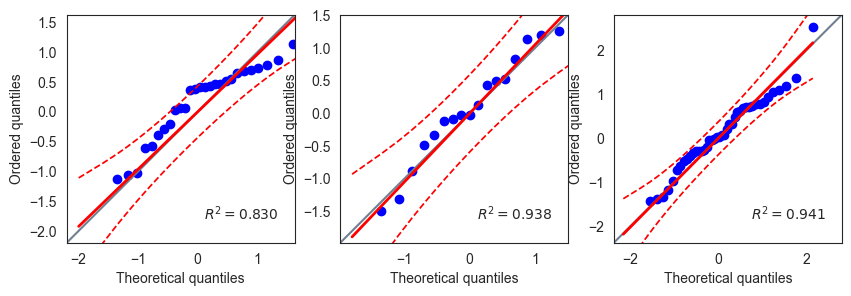

In [44]:
graph_df_anova = graph_df.dropna(subset=['active_year']).copy()

# qq-plots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,3))
pg.qqplot(graph_df_anova.query("Community == 'Group 1'").active_year, dist='norm', ax=axs[0])
pg.qqplot(graph_df_anova.query("Community == 'Group 2'").active_year, dist='norm', ax=axs[1])
pg.qqplot(graph_df_anova.query("Community == 'Group 3'").active_year, dist='norm', ax=axs[2])

plt.show()

In [45]:
# Shapiro-Wilk tests
groups = [graph_df_anova.query("Community == 'Group 1'").active_year.values,
          graph_df_anova.query("Community == 'Group 2'").active_year.values,
          graph_df_anova.query("Community == 'Group 3'").active_year.values]

for group in groups:
    print(pg.normality(group))

          W      pval  normal
0  0.840338  0.000392   False
          W      pval  normal
0  0.936238  0.225382    True
          W      pval  normal
0  0.952298  0.067014    True


Now let's test for equality of variances. This consdition is clearly violated! Group 3 has a much greater variance as can be seen in the boxplot above.

In [46]:
pg.homoscedasticity(groups)

,W,pval,equal_var
levene,6.727548,0.001893,False


Given that the results of classical ANOVA can be afffected by the violation of homoscedasticity when group sizes are unequal (as they are in our case), we go for a Welch-ANOVA which is more robust in this situation.

In [47]:
aov = pg.welch_anova(dv='active_year', between='Community', data=graph_df_anova)
aov.round(3)

,Source,ddof1,ddof2,F,p-unc,np2
0,Community,2,55.593,34.973,0.0,0.447


According to the Welch-Test $F(2, 53.101) = 34.399, p < .001, \eta_p^2 = .444$, the distributions of the composers' active years differ statistically significantly for the different network communities.

For post-hoc analysis, we perform pairwise Games-Howell tests.

In [48]:
pg.pairwise_gameshowell(dv='active_year', between='Community', data=graph_df_anova, effsize='cohen').round(3)

,A,B,mean(A),mean(B),diff,se,T,df,pval,cohen
0,Group 1,Group 2,1586.783,1593.921,-7.138,5.203,-1.372,41.916,0.365,-0.391
1,Group 1,Group 3,1586.783,1536.580,50.204,6.842,7.338,66.300,0.000,1.543
2,Group 2,Group 3,1593.921,1536.580,57.342,7.046,8.138,60.989,0.000,1.684


In [49]:
graph_df_anova.groupby('Community')['active_year'].agg(['mean', 'std']).round(3)

,mean,std
Community,,
Group 1,1586.783,19.071
Group 2,1593.921,16.856
Group 3,1536.580,39.068


We performed pairwise Games-Howell Tests to determine which pairs of the three groups differ significantly with respect to their mean active years. The results indicate that the composers' active years in Group 3 $(M=1536.580, SD=39.068)$ differ significantly $(p < .001)$ from those in both Group 1 $(M=1586.783, SD=19.071)$ and Group 2 $(M=1593.944, SD=17.344)$ with a Cohen's $d$ of $1.543$ and $1.671$ respectively. The comparison between Group 1 and 2 did not reveal a significant difference.